<a href="https://colab.research.google.com/github/RahulNaidu710/datasciencecoursera/blob/master/Copy_of_Kaggle_catsvsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
from shutil import copyfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import pickle

In [0]:
!unrar x "/content/drive/My Drive/cats-vs-dogs.rar" "/tmp"

In [0]:
base_dir = '/tmp/cats-vs-dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'Cat')
train_dogs_dir = os.path.join(train_dir, 'Dog')

In [4]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
train_cats_fnames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or -1))
train_dogs_fnames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or -1))
test_fnames = os.listdir(test_dir)
test_fnames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or -1))
print(train_cats_fnames[:10])
print(train_dogs_fnames[:10])
print(test_fnames[:10])

['Thumbs.db', '0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
['Thumbs.db', '0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg']


In [5]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))
print('total test set images :', len(os.listdir(test_dir)))

total training cat images : 12501
total training dog images : 12501
total test set images : 12500


In [0]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

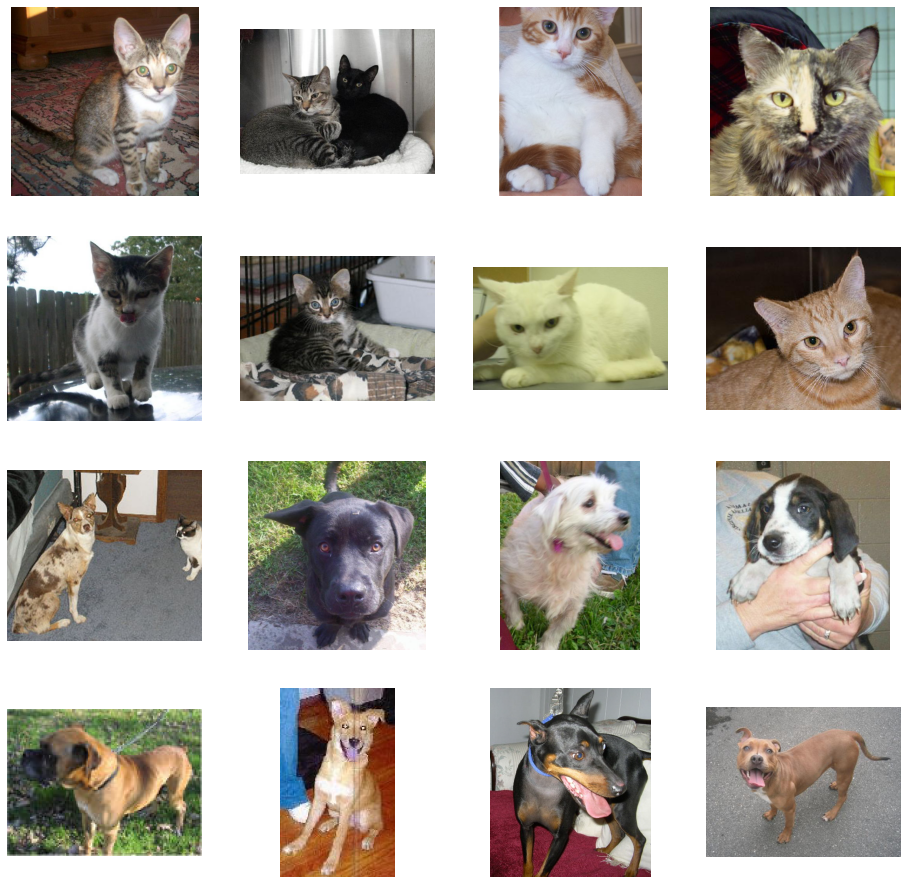

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cats_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dogs_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [0]:
try:
    os.makedirs('/tmp/cats-vs-dogs/training/Cat')
    os.makedirs('/tmp/cats-vs-dogs/training/Dog')
    os.makedirs('/tmp/cats-vs-dogs/validation/Cat')
    os.makedirs('/tmp/cats-vs-dogs/validation/Dog')
except OSError:
    pass

In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + ' is of 0 length, so ignoring it')
    
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
        
CAT_SOURCE_DIR = "/tmp/cats-vs-dogs/train/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-vs-dogs/training/Cat/"
TESTING_CATS_DIR = "/tmp/cats-vs-dogs/validation/Cat/"
DOG_SOURCE_DIR = "/tmp/cats-vs-dogs/train/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-vs-dogs/training/Dog/"
TESTING_DOGS_DIR = "/tmp/cats-vs-dogs/validation/Dog/"

In [11]:
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is of 0 length, so ignoring it
11702.jpg is of 0 length, so ignoring it


In [12]:
print(len(os.listdir('/tmp/cats-vs-dogs/training/Cat/')))
print(len(os.listdir('/tmp/cats-vs-dogs/training/Dog/')))
print(len(os.listdir('/tmp/cats-vs-dogs/validation/Cat/')))
print(len(os.listdir('/tmp/cats-vs-dogs/validation/Dog/')))

11250
11250
1250
1250


In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [0]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
validation_datagen = ImageDataGenerator(rescale = 1/255.)

training_dir = '/tmp/cats-vs-dogs/training'
validation_dir = '/tmp/cats-vs-dogs/validation'

train_generator = train_datagen.flow_from_directory(training_dir, batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (150, 150))


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [18]:
history = model.fit(train_generator,
                              validation_data = validation_generator,
                              steps_per_epoch = 22500//20,
                              epochs = 7,
                              validation_steps = 2500//20
                              )

Epoch 1/7
1125/1125 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7056

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 139s 124ms/step - loss: 0.5665 - accuracy: 0.7056 - val_loss: 0.4920 - val_accuracy: 0.7608
Epoch 2/7
1125/1125 [==============================] - 137s 122ms/step - loss: 0.4545 - accuracy: 0.7881 - val_loss: 0.4536 - val_accuracy: 0.8004
Epoch 3/7
1125/1125 [==============================] - 135s 120ms/step - loss: 0.3938 - accuracy: 0.8250 - val_loss: 0.4812 - val_accuracy: 0.8016
Epoch 4/7
1125/1125 [==============================] - 137s 121ms/step - loss: 0.3486 - accuracy: 0.8491 - val_loss: 0.4497 - val_accuracy: 0.8268
Epoch 5/7
1125/1125 [==============================] - 136s 121ms/step - loss: 0.3232 - accuracy: 0.8679 - val_loss: 0.3765 - val_accuracy: 0.8416
Epoch 6/7
1125/1125 [==============================] - 135s 120ms/step - loss: 0.3038 - accuracy: 0.8785 - val_loss: 0.4034 - val_accuracy: 0.8280
Epoch 7/7
1125/1125 [==============================] - 137s 122ms/step - loss: 0.2938 - accuracy: 0.8873 - val_loss: 0.3592 - va

In [0]:
#model.save('model.h5')
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

Text(0.5, 1.0, 'Training and validation loss')

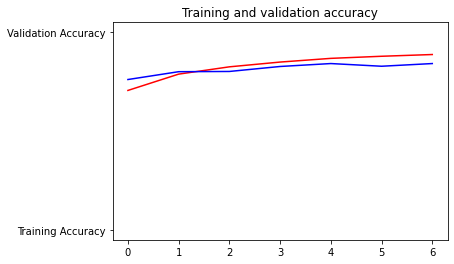

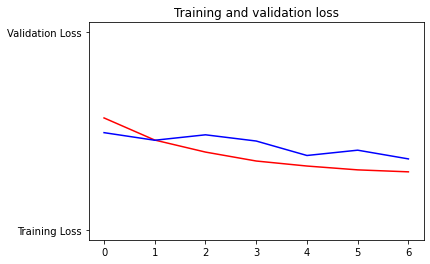

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')

In [0]:
test_data = []
img_size = 150

datadir = "/tmp/cats-vs-dogs/test"
path = os.path.join(datadir)
for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, (img_size, img_size))
    test_data.append(new_array)

In [0]:
test = np.array(test_data).reshape(-1, img_size, img_size, 3)
test = test/255.0

In [0]:
preds = model.predict_proba(test)
print(preds)

In [0]:
submission = pd.DataFrame(preds)
submission = submission.rename(columns = {0: 'label'})
submission = submission.reset_index()
submission = submission.rename(columns = {'index': 'id'})
submission['id'] = submission.index + 1
submission.to_csv('submissiona.csv', index = False)